<a href="https://colab.research.google.com/github/Sarah0711/CUDA-Vision-Lab/blob/main/Robot_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and Load the data.zip folder in cuda vision folder, it is a dummy data to check not correctly labelled





In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
import os

In [ ]:
if not os.path.exists('data.zip'): 
  !wget --no-check-certificate !wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zAQUyVYmAe4b-5BkxJZMLZ5azIgksR1V' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zAQUyVYmAe4b-5BkxJZMLZ5azIgksR1V" -O  data.zip && rm -rf /tmp/cookies.txt

--2020-01-15 21:03:31--  http://!wget/
Resolving !wget (!wget)... failed: Name or service not known.
wget: unable to resolve host address ‘!wget’
--2020-01-15 21:03:31--  https://docs.google.com/uc?export=download&confirm=Dx_R&id=1zAQUyVYmAe4b-5BkxJZMLZ5azIgksR1V
Resolving docs.google.com (docs.google.com)... 74.125.195.139, 74.125.195.101, 74.125.195.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-10-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oro0n1vpljlb48ffussji9qfqava0s18/1579118400000/02751230155057180797/*/1zAQUyVYmAe4b-5BkxJZMLZ5azIgksR1V?e=download [following]
--2020-01-15 21:03:31--  https://doc-10-14-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/oro0n1vpljlb48ffussji9qfqava0s18/1579118400000/02751230155057180797/*/1zAQUyVYmAe4b-5BkxJZMLZ5azIgksR1V?e=download
Resolving doc-10-14-docs.googleu

In [ ]:

!unzip 'data.zip'

In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torchvision.models as models
import random
import torchvision
import numpy as np 
import matplotlib.pyplot as plt 
import time
from math import log, exp
from hyperopt import fmin, tpe, hp
from torch.optim import lr_scheduler
import copy

In [ ]:
if torch.cuda.is_available():
    avDev = torch.device("cuda")
else:
    avDev = torch.device("cpu")

In [ ]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True

In [ ]:
def show_images(img):
    img = img / 2 + 0.5     # unnormalize
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [ ]:
'''
STEP 1: LOADING DATASET
'''

train_transform = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
test_transform = transforms.Compose([
        transforms.Resize((256,256)),
        # transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_path = "data/"
# test_path = "data/"


train_path = "data/train/"
test_path = "data/test/"

train_dataset = torchvision.datasets.ImageFolder(
    root=train_path,
    transform=train_transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=test_path,
    transform=test_transform
)
dataset_sizes = {'train':len(train_dataset), 'val':len(test_dataset)}

In [ ]:
batch_size = 64
max_epochs = 25

6


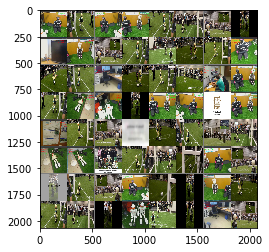

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           )
 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          )


dataloaders = {'train':train_loader, 'val':test_loader}
dataiter = train_loader.__iter__()
print(len(train_loader))
images, labels = dataiter.next()

show_images(torchvision.utils.make_grid(images))

In [ ]:
def plot_learning_curve(loss_errors):
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.plot(np.array(loss_errors))

In [ ]:
losses=[]

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 0.0
    number_of_epoch_stop = 10
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(avDev)
                labels = labels.to(avDev)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val':
                if epoch_acc > best_acc:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0

                else:
                    epochs_no_improve += 1
        print()

        if epochs_no_improve == number_of_epoch_stop:
          print('Early stopping!')
          break        


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,best_loss

In [ ]:

def hp_train(args):
  
  densenet = args[0]
  print("Chosen Layers:", densenet)
  optimizer = args[1]
  print("Chosen Optimizer:", optimizer)
  scheduler = args[2]
  print("Chosen Scheduler:", scheduler)
  criterion = args[3]
  print("Chosen Criterion:", criterion)

  model = densenet(pretrained=True) 
  num_ftrs = model.classifier.in_features
  model.classifier = nn.Linear(num_ftrs, 2)

  model = model.to(avDev)

  learning_rate = 0.001

  optimizer = optimizer(list(model.parameters()), lr=learning_rate)
  scheduler = scheduler(optimizer, step_size=7, gamma=0.1)
  _,loss = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=max_epochs)
  losses.append(log(loss))
  return loss
    

In [ ]:
densenets = [models.densenet121]#,models.densenet201,models.densenet169,models.densenet161]
optimizers = [torch.optim.SGD,torch.optim.Adam]
schedulers = [lr_scheduler.StepLR]#,lr_scheduler.CyclicLR,lr_scheduler.CosineAnnealingLR
criterions = [nn.CrossEntropyLoss()]

space = [hp.choice('Densenets',densenets),hp.choice('Optimizers',optimizers),hp.choice('Schedulers',schedulers),hp.choice('Criterions',criterions)]

In [ ]:
best_classifier = fmin(hp_train,space,algo=tpe.suggest,max_evals=6)
densenet = densenets[(best_classifier['Densenets'])]
optimizer = optimizers[(best_classifier['Optimizers'])]
scheduler = schedulers[(best_classifier['Schedulers'])]
criterion = criterions[(best_classifier['Criterions'])]

Chosen Layers:
<function densenet121 at 0x7f544b9177b8>
Chosen Optimizer:
<class 'torch.optim.adam.Adam'>
Chosen Scheduler:
<class 'torch.optim.lr_scheduler.StepLR'>
Chosen Criterion:
CrossEntropyLoss()
  0%|          | 0/6 [00:00<?, ?it/s, best loss: ?]

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth

  0%|          | 0.00/30.8M [00:00<?, ?B/s]

  8%|7         | 2.44M/30.8M [00:00<00:01, 25.3MB/s]

 15%|#4        | 4.57M/30.8M [00:00<00:01, 24.4MB/s]

 23%|##2       | 7.00M/30.8M [00:00<00:01, 24.6MB/s]

 30%|##9       | 9.12M/30.8M [00:00<00:00, 23.8MB/s]

 37%|###7      | 11.6M/30.8M [00:00<00:00, 23.8MB/s]

 45%|####4     | 13.9M/30.8M [00:00<00:00, 23.9MB/s]

 52%|#####2    | 16.1M/30.8M [00:00<00:00, 23.7MB/s]

 60%|#####9    | 18.4M/30.8M [00:00<00:00, 23.9MB/s]

 68%|######7   | 20.9M/30.8M [00:00<00:00, 24.5MB/s]

 76%|#######5  | 23.4M/30.8M [00:01<00:00, 24.8MB/s]

 83%|########3 | 25.7M/30.8M [00:01<00:00, 23.9MB/s]

 91%|######### | 28.1M/30.8M [00:01<00:00, 23.7MB/s]

 98%|#########8| 30.3M/30.8M [00:01<00:00, 23.5MB/s]

100%|##########| 30.8M/30.8M [00:01<00:00, 23.8MB/s]



Epoch 0/24
----------
  0%|          | 0/6 [00:11<?, ?it/s, best loss: ?]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)



train Loss: 0.2814 Acc: 0.8765
val Loss: 0.2448 Acc: 0.9268
Epoch 1/24
----------
train Loss: 0.0699 Acc: 0.9729
val Loss: 0.0387 Acc: 1.0000
Epoch 2/24
----------
train Loss: 0.0311 Acc: 0.9880
val Loss: 0.2707 Acc: 0.9187
Epoch 3/24
----------
train Loss: 0.0106 Acc: 0.9970
val Loss: 0.2289 Acc: 0.9512
Epoch 4/24
----------
train Loss: 0.0181 Acc: 0.9940
val Loss: 0.1903 Acc: 0.9268
Epoch 5/24
----------
train Loss: 0.0138 Acc: 0.9940
val Loss: 0.2269 Acc: 0.9593
Epoch 6/24
----------
train Loss: 0.0060 Acc: 1.0000
val Loss: 0.0290 Acc: 0.9919
Epoch 7/24
----------
train Loss: 0.0029 Acc: 1.0000
val Loss: 0.0102 Acc: 1.0000
Epoch 8/24
----------
train Loss: 0.0038 Acc: 1.0000
val Loss: 0.0088 Acc: 1.0000
Epoch 9/24
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.0089 Acc: 1.0000
Epoch 10/24
----------
train Loss: 0.0048 Acc: 0.9970
val Loss: 0.0082 Acc: 1.0000
Epoch 11/24
----------
train Loss: 0.0013 Acc: 1.0000
val Loss: 0.0065 Acc: 1.0000
Early stopping!
Training complete in

In [ ]:
model = densenet(pretrained=True) 
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, 2)
model = model.to(avDev)
learning_rate = 0.001
optimizer = optimizer(list(model.parameters()), lr=learning_rate)
scheduler = scheduler(optimizer, step_size=7, gamma=0.1)
model,loss = train_model(model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, num_epochs=max_epochs)


Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2309 Acc: 0.9127
val Loss: 0.1661 Acc: 0.8943

Epoch 1/24
----------
train Loss: 0.0248 Acc: 0.9940
val Loss: 0.7551 Acc: 0.8618

Epoch 2/24
----------
train Loss: 0.0511 Acc: 0.9819
val Loss: 0.7261 Acc: 0.8049

Epoch 3/24
----------
train Loss: 0.0310 Acc: 0.9910
val Loss: 0.4489 Acc: 0.8699

Epoch 4/24
----------
train Loss: 0.0099 Acc: 0.9970
val Loss: 0.3708 Acc: 0.8862

Epoch 5/24
----------
train Loss: 0.0091 Acc: 0.9970
val Loss: 0.0453 Acc: 0.9756

Epoch 6/24
----------
train Loss: 0.0035 Acc: 1.0000
val Loss: 0.0139 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.0012 Acc: 1.0000
val Loss: 0.0088 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0017 Acc: 1.0000
val Loss: 0.0088 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0078 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0014 Acc: 1.0000
val Loss: 0.0072 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0007 Acc: 1.0000
val Loss: 0.0046 Acc: 1.0000

Epoch 12/24
----------
t

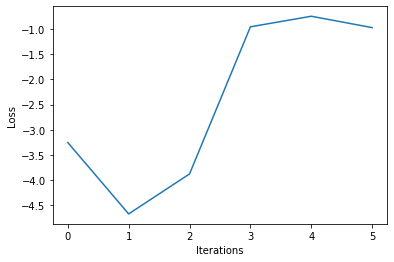

In [ ]:
plot_learning_curve(losses) 